# Hava Kirliliği Verileri ile Astım Atak Riski Tahmini ve Türkiye Geneli Risk Haritalaması

Bu notebook, hava kirliliği verilerini kullanarak astım atağı riskini tahmin etmek ve Türkiye geneli için bir risk haritası oluşturmak amacıyla gerçekleştirilen veri analizi ve makine öğrenmesi sürecini içermektedir. Data klasörü altındaki tüm OpenAQ ölçüm dosyaları analiz edilmektedir.

## Gerekli Kütüphanelerin Import Edilmesi

Proje için gereken Python kütüphanelerini import edelim.

In [1]:
# Temel veri analizi ve işleme için kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Makine öğrenmesi için kütüphaneler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Harita görselleştirme için kütüphaneler
import folium
from folium.plugins import HeatMap
import geopandas as gpd

# CPU çekirdek sayısı ile ilgili hataları önlemek için
import os
# İş parçacığı sayısını sınırlayalım
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

# joblib'in paralel işleme davranışını düzenleyelim
import joblib
joblib.parallel.BACKENDS['loky']._count_physical_cores = lambda: 2

# Matplotlib'in iş parçacığı sayısını sınırla
plt.rcParams['agg.path.chunksize'] = 10000

# Ayarlar
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")

# Grafiklerin yerleşimi için
import warnings
warnings.filterwarnings('ignore')

print("Kütüphaneler başarıyla yüklendi!")

Kütüphaneler başarıyla yüklendi!


In [16]:
# Veri setlerinin bulunduğu klasör
data_folder = 'data/'

def load_all_openaq_files():
    import glob
    import os
    
    all_files = glob.glob(os.path.join(data_folder, "openaq_location_*_measurments.csv"))
    
    # Tüm dosyaları birleştir
    df_list = []
    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)
    
    # Tüm dosyalar tek bir DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)
    
    print(f"Toplam {len(all_files)} dosya okundu.")
    print(f"Toplam {combined_df.shape[0]} satır veri yüklendi.")
    
    return combined_df

df_raw = load_all_openaq_files()

print("\nVeri seti sütunları:")
print(df_raw.columns.tolist())

print("\nVeri setinin ilk 5 satırı:")
df_raw.head()

Toplam 200 dosya okundu.
Toplam 783376 satır veri yüklendi.

Veri seti sütunları:
['location_id', 'location_name', 'parameter', 'value', 'unit', 'datetimeUtc', 'datetimeLocal', 'timezone', 'latitude', 'longitude', 'country_iso', 'isMobile', 'isMonitor', 'owner_name', 'provider']

Veri setinin ilk 5 satırı:


,location_id,location_name,parameter,value,unit,datetimeUtc,datetimeLocal,timezone,latitude,longitude,country_iso,isMobile,isMonitor,owner_name,provider
0,1416421,Şırnak - Silopi.,co,0.129,µg/m³,2023-08-11T08:00:00Z,2023-08-11T11:00:00+03:00,Europe/Istanbul,37.247085,42.464936,NaN,NaN,NaN,Unknown Governmental Organization,Türkiye
1,1416421,Şırnak - Silopi.,co,0.132,µg/m³,2023-08-11T10:00:00Z,2023-08-11T13:00:00+03:00,Europe/Istanbul,37.247085,42.464936,NaN,NaN,NaN,Unknown Governmental Organization,Türkiye
2,1416421,Şırnak - Silopi.,no2,14.063,µg/m³,2023-08-11T08:00:00Z,2023-08-11T11:00:00+03:00,Europe/Istanbul,37.247085,42.464936,NaN,NaN,NaN,Unknown Governmental Organization,Türkiye
3,1416421,Şırnak - Silopi.,no2,15.004,µg/m³,2023-08-11T10:00:00Z,2023-08-11T13:00:00+03:00,Europe/Istanbul,37.247085,42.464936,NaN,NaN,NaN,Unknown Governmental Organization,Türkiye
4,1416421,Şırnak - Silopi.,o3,46.331,µg/m³,2023-08-11T08:00:00Z,2023-08-11T11:00:00+03:00,Europe/Istanbul,37.247085,42.464936,NaN,NaN,NaN,Unknown Governmental Organization,Türkiye


DETAYLI VERİ ANALİZİ ÖZET RAPORU
Veri Seti Boyutu: 783,376 satır x 15 sütun
📅 Veri Zaman Aralığı: 12-12-2016 - 13-10-2023 (2495 gün)
Toplam 200 farklı ölçüm istasyonundan veri bulunmaktadır.
Her şehir için tespit edilen tüm ilçeler:
   1. Giresun - Gemilercekeği: 6,000 ölçüm
   2. Çankırı: 6,000 ölçüm
   3. Kastamonu: 6,000 ölçüm
   4. Bartın: 6,000 ölçüm
   5. Karaman: 6,000 ölçüm

🔍 Toplam 7 farklı kirlilik parametresi ölçülmüştür:
   - pm10: 189,028 ölçüm (24.1%)
   - so2: 169,765 ölçüm (21.7%)
   - no2: 145,094 ölçüm (18.5%)
   - o3: 105,340 ölçüm (13.4%)
   - co: 96,613 ölçüm (12.3%)
   - pm25: 77,473 ölçüm (9.9%)
   - temperature: 63 ölçüm (0.0%)

Eksik Veri Analizi:
   1. country_iso: 783,376 eksik değer (100.0%)
   2. isMobile: 783,376 eksik değer (100.0%)
   3. isMonitor: 783,376 eksik değer (100.0%)

Eksik Veri Analizi:
   1. country_iso: 783,376 eksik değer (100.0%)
   2. isMobile: 783,376 eksik değer (100.0%)
   3. isMonitor: 783,376 eksik değer (100.0%)


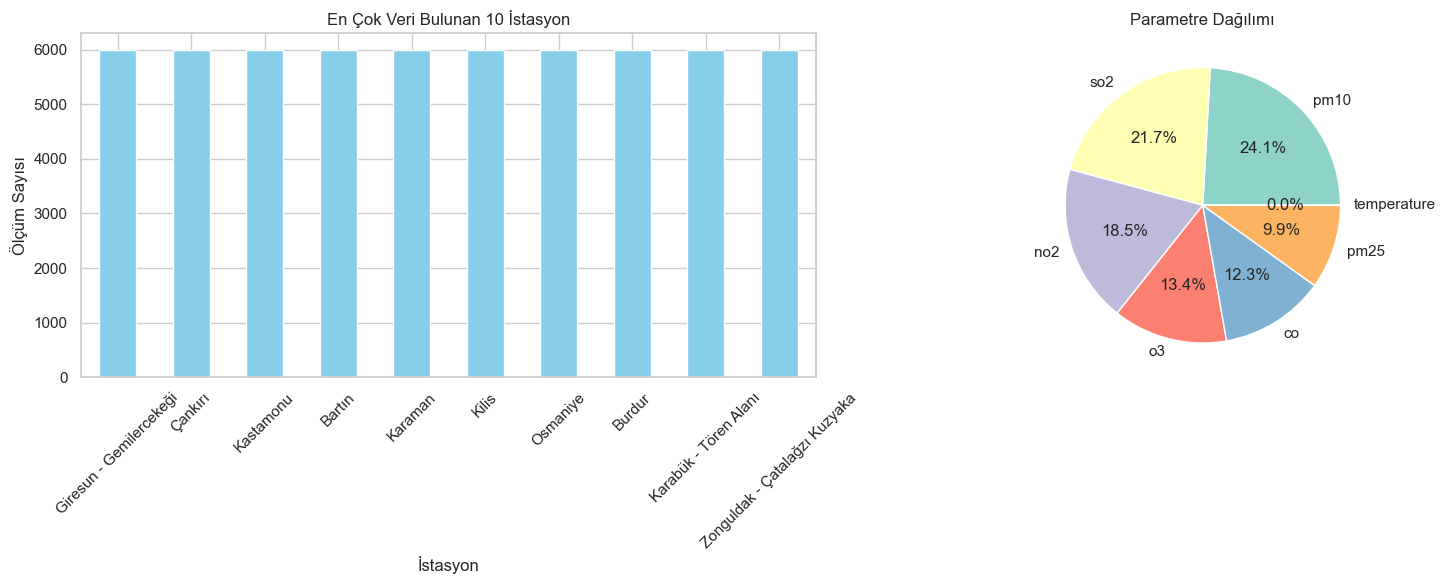


📈 Ölçüm Değerleri İstatistikleri:

   PM10 İstatistikleri:
     Min: -242.00, Max: 111642687.88, Ortalama: 1389.80, Medyan: 48.69

   SO2 İstatistikleri:
     Min: -35.00, Max: 66859.72, Ortalama: 27.19, Medyan: 10.83

   NO2 İstatistikleri:
     Min: -88.00, Max: 1360.00, Ortalama: 44.53, Medyan: 30.87

   O3 İstatistikleri:
     Min: -349.00, Max: 2073.00, Ortalama: 35.03, Medyan: 29.20

   CO İstatistikleri:
     Min: -419418.00, Max: 145933500000.00, Ortalama: 14135576.78, Medyan: 593000.00

   PM25 İstatistikleri:
     Min: -0.03, Max: 609.76, Ortalama: 27.86, Medyan: 21.75

   TEMPERATURE İstatistikleri:
     Min: 11.64, Max: 23.34, Ortalama: 16.07, Medyan: 16.09

   O3 İstatistikleri:
     Min: -349.00, Max: 2073.00, Ortalama: 35.03, Medyan: 29.20

   CO İstatistikleri:
     Min: -419418.00, Max: 145933500000.00, Ortalama: 14135576.78, Medyan: 593000.00

   PM25 İstatistikleri:
     Min: -0.03, Max: 609.76, Ortalama: 27.86, Medyan: 21.75

   TEMPERATURE İstatistikleri:
     Min

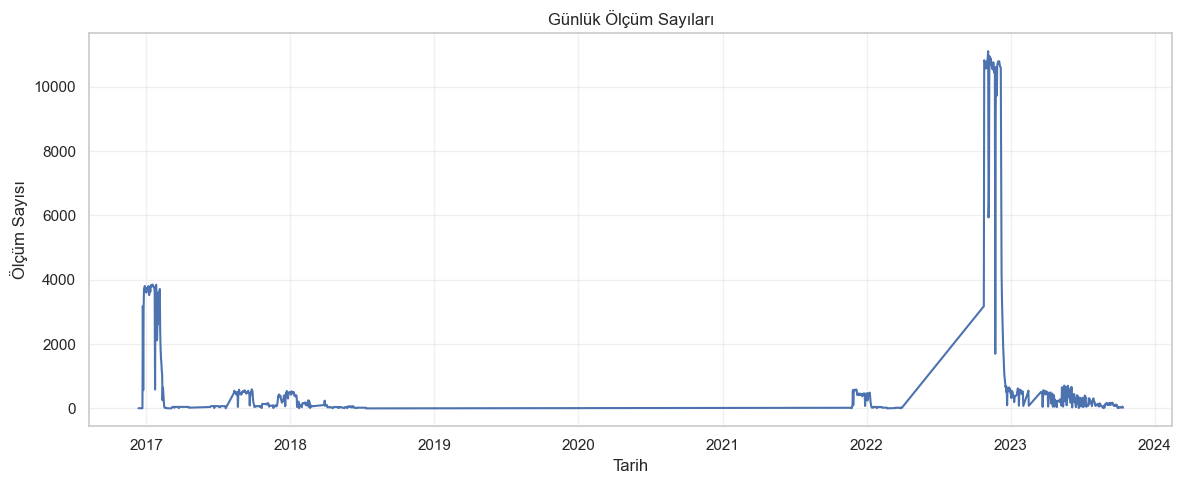


Veri seti analizi tamamlandı.


In [17]:
print("DETAYLI VERİ ANALİZİ ÖZET RAPORU")
print("=" * 50)

# 1. Genel Veri Boyutu
print(f"Veri Seti Boyutu: {df_raw.shape[0]:,} satır x {df_raw.shape[1]} sütun")

# 2. Tarih aralığı
if 'datetimeLocal' in df_raw.columns:
    df_raw['datetimeLocal'] = pd.to_datetime(df_raw['datetimeLocal'])
    min_date = df_raw['datetimeLocal'].min().strftime('%d-%m-%Y')
    max_date = df_raw['datetimeLocal'].max().strftime('%d-%m-%Y')
    date_range = (df_raw['datetimeLocal'].max() - df_raw['datetimeLocal'].min()).days
    print(f"📅 Veri Zaman Aralığı: {min_date} - {max_date} ({date_range} gün)")

# 3. İstasyon analizi
station_counts = df_raw['location_name'].value_counts()
print(f"Toplam {len(station_counts)} farklı ölçüm istasyonundan veri bulunmaktadır.")
print("Her şehir için tespit edilen tüm ilçeler:")
for idx, (station, count) in enumerate(station_counts.head(5).items(), 1):
    print(f"   {idx}. {station}: {count:,} ölçüm")

# 4. Ölçüm parametreleri analizi
param_counts = df_raw['parameter'].value_counts()
print(f"\n🔍 Toplam {len(param_counts)} farklı kirlilik parametresi ölçülmüştür:")
for param, count in param_counts.items():
    print(f"   - {param}: {count:,} ölçüm ({count/len(df_raw)*100:.1f}%)")

# 5. Eksik veri analizi
missing_data = df_raw.isnull().sum()
missing_percent = (missing_data / len(df_raw)) * 100
missing_df = pd.DataFrame({
    'Eksik Değerler': missing_data,
    'Eksik Yüzde': missing_percent
})
missing_df = missing_df[missing_df['Eksik Değerler'] > 0].sort_values('Eksik Değerler', ascending=False)

print(f"\nEksik Veri Analizi:")
if len(missing_df) > 0:
    for idx, (col, row) in enumerate(missing_df.iterrows(), 1):
        print(f"   {idx}. {col}: {int(row['Eksik Değerler']):,} eksik değer ({row['Eksik Yüzde']:.1f}%)")
else:
    print("   Eksik veri bulunmamaktadır.")

# 6. Görselleştirme: İstasyon ve parametre dağılımları
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# İstasyon sayısı grafiği
station_counts.head(10).plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('En Çok Veri Bulunan 10 İstasyon')
ax1.set_xlabel('İstasyon')
ax1.set_ylabel('Ölçüm Sayısı')
ax1.tick_params(axis='x', rotation=45)

# Parametre dağılımı pasta grafiği
param_counts.plot(kind='pie', autopct='%1.1f%%', ax=ax2, colors=sns.color_palette("Set3"))
ax2.set_title('Parametre Dağılımı')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

# 7. Ölçüm değerlerinin temel istatistikleri
print("\n📈 Ölçüm Değerleri İstatistikleri:")
# Parametre bazında özet istatistikler
for param in param_counts.index:
    param_data = df_raw[df_raw['parameter'] == param]['value']
    print(f"\n   {param.upper()} İstatistikleri:")
    print(f"     Min: {param_data.min():.2f}, Max: {param_data.max():.2f}, Ortalama: {param_data.mean():.2f}, Medyan: {param_data.median():.2f}")
    
# 8. Zaman içinde ölçüm dağılımı
if 'datetimeLocal' in df_raw.columns:
    df_raw['date'] = df_raw['datetimeLocal'].dt.date
    date_measurement_count = df_raw.groupby('date').size()
    
    plt.figure(figsize=(12, 5))
    date_measurement_count.plot()
    plt.title('Günlük Ölçüm Sayıları')
    plt.xlabel('Tarih')
    plt.ylabel('Ölçüm Sayısı')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
print("\nVeri seti analizi tamamlandı.")

Veri setinde toplam 87 şehir tespit edildi.
Her şehir için tespit edilen tüm ilçeler:
- Şırnak: 2 bölge (Silopi., Merkez)
- MTHM Seyyar Araç-Tekirdağ-Muratlı: 1 bölge (Merkez)
- Eşme: 1 bölge (Merkez)
- Mersin: 6 bölge (Tasucu, Tarsus, Akdeniz, Huzurkent, Toroslar, Yenişehir)
- Kahramanmaraş: 4 bölge (Onikişubat, Dulkadiroğlu, Kent, Elbistan)
- Trabzon: 5 bölge (Uzungöl, Meydan, Valilik, Beşirli, Akçaabat)
- Muğla: 5 bölge (Milas, Fethiye, Trafik, Yatağan, Musluhittin)
- Giresun: 2 bölge (Gemilercekeği, Merkez)
- Aydın: 6 bölge (Söke, Germencik, Efeler, Didim, Nazilli, Merkez)
- Zonguldak: 7 bölge (Kilimli, Çaycuma, Kozlu, Trafik, Çatalağzı, Karadeniz, Muslu)
- Denizli: 3 bölge (Sümer, Honaz, Bayramyeri)
- İzmir: 15 bölge (Bornova, Ödemiş, Çeşme, Torbalı, Bayraklı, Karşıyaka, Eğitim, Çiğli, Yenifoça, Karaburun, Aliağa, Menemen, Konak, Karabağlar, Gaziemir)
- Hatay: 5 bölge (Vali, İskenderun, Antakya, Samandağ, Mustafa)
- Şanlıurfa: 1 bölge (Merkez)
- Isparta: 1 bölge (Merkez)
- Muş: 1 

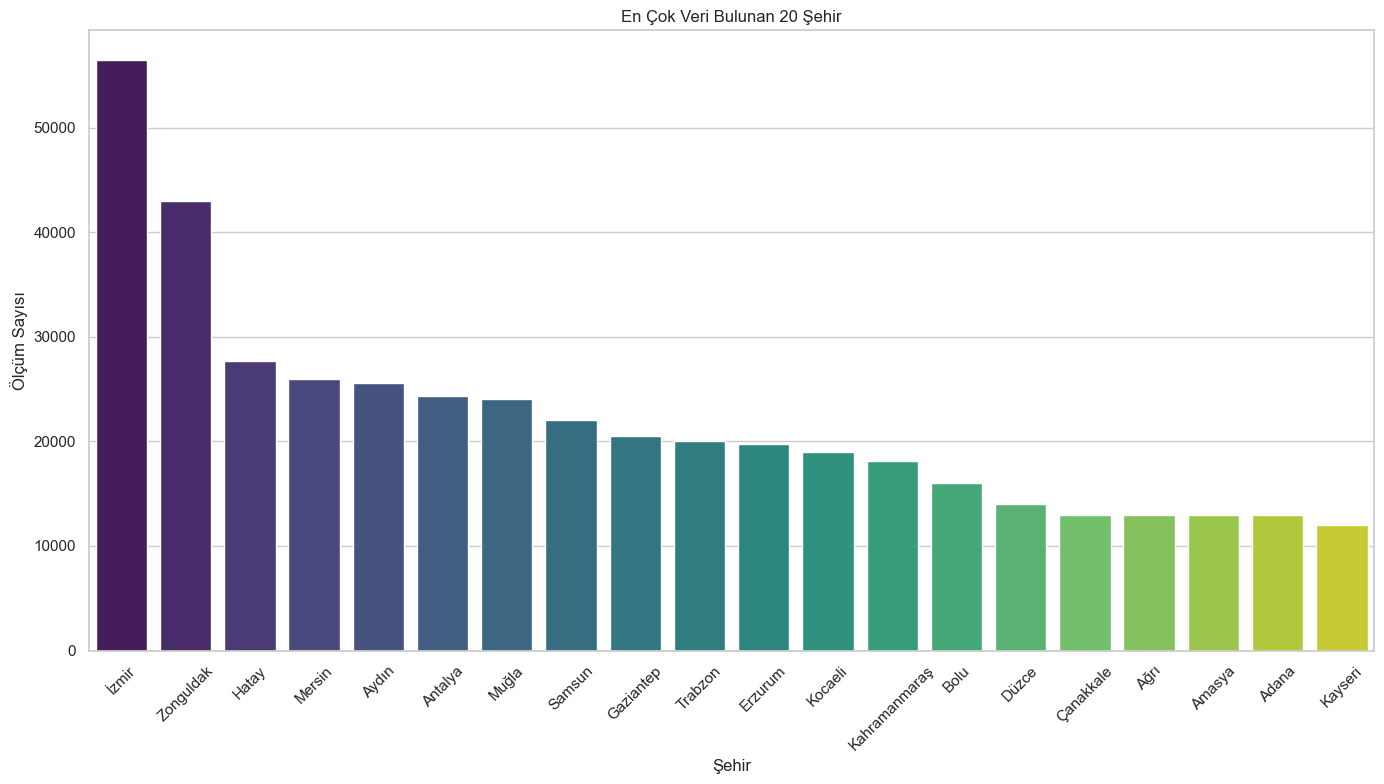

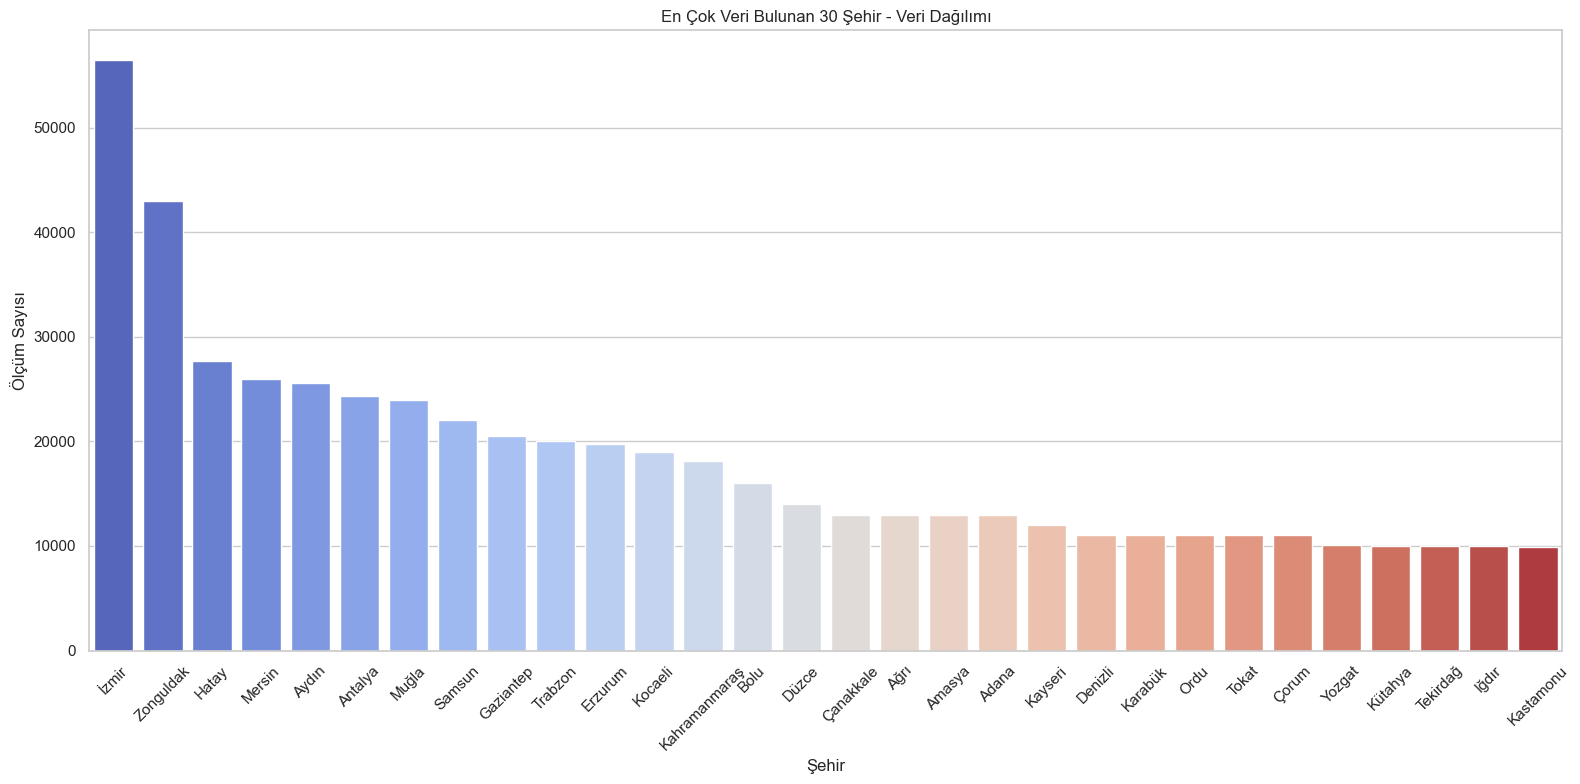


Türkiye geneli veri yoğunluğu haritası:


In [18]:
# Lokasyonlar için konum bilgilerini düzenleyelim
location_info = df_raw.groupby(['location_name', 'latitude', 'longitude']).size().reset_index(name='measurement_count')

# Tüm benzersiz lokasyon isimlerini alalım
unique_locations = df_raw['location_name'].unique()

# Lokasyon adlarından şehir ve ilçe bilgilerini otomatik olarak çıkartalım
def extract_city_district_from_name(location_name):
    # Tipik format: "Şehir - İlçe" veya "Şehir"
    parts = location_name.split(' - ')
    
    if len(parts) >= 2:
        city = parts[0].strip()
        district = parts[1].strip()
        # İlçe içinde fazladan bilgi varsa (örn: "İlkadım Hastane")
        district = district.split(' ')[0] if ' ' in district else district
    else:
        city = parts[0].strip()
        district = 'Merkez'
        
    return city, district

# Tüm lokasyonlardan şehir ve ilçeleri çıkaralım
cities_districts_auto = {}

for location in unique_locations:
    city, district = extract_city_district_from_name(location)
    
    # Şehir sözlükte yoksa ekleyelim
    if city not in cities_districts_auto:
        cities_districts_auto[city] = []
    
    # İlçeyi ekleyelim (eğer zaten yoksa)
    if district not in cities_districts_auto[city]:
        cities_districts_auto[city].append(district)

print(f"Veri setinde toplam {len(cities_districts_auto)} şehir tespit edildi.")
print(f"Her şehir için tespit edilen tüm ilçeler:")
for city, districts in cities_districts_auto.items():
    print(f"- {city}: {len(districts)} bölge ({', '.join(districts)})")

cities_districts = cities_districts_auto

def extract_location_info(location_name):
    city, district = extract_city_district_from_name(location_name)
    return city, district

location_info['city'], location_info['district'] = zip(*location_info['location_name'].apply(extract_location_info))

city_data = location_info.groupby('city')['measurement_count'].sum().reset_index()
city_data = city_data.sort_values(by='measurement_count', ascending=False)

# İlk 15 şehir
plt.figure(figsize=(14, 8))
sns.barplot(x='city', y='measurement_count', data=city_data.head(20), palette='viridis')
plt.title('En Çok Veri Bulunan 20 Şehir')
plt.xlabel('Şehir')
plt.ylabel('Ölçüm Sayısı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tüm şehirler için veri dağılımı
all_city_data = city_data.copy()

plt.figure(figsize=(16, 8))
if len(all_city_data) > 30:
    # Eğer 30'dan fazla şehir varsa, en çok veri bulunan 30 şehri göster
    top_cities = all_city_data.head(30)
    sns.barplot(x='city', y='measurement_count', data=top_cities, palette='coolwarm')
    plt.title('En Çok Veri Bulunan 30 Şehir - Veri Dağılımı')
else:
    sns.barplot(x='city', y='measurement_count', data=all_city_data, palette='coolwarm')
    plt.title('Tüm Şehirler - Veri Dağılımı')
plt.xlabel('Şehir')
plt.ylabel('Ölçüm Sayısı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

def get_color_for_measurement(count):
    color_ranges = {
        1000: 'green',     # 0-1000
        2000: 'lime',      # 1001-2000
        3000: 'yellow',    # 2001-3000
        4000: 'orange',    # 3001-4000
        5000: 'orangered', # 4001-5000
        float('inf'): 'red'# 5001+
    }
    
    for threshold, color in sorted(color_ranges.items()):
        if count <= threshold:
            return color
    return 'red'

# Türkiye geneli harita oluştur
turkey_map = folium.Map(location=[39.0, 35.0], zoom_control=True, zoom_start=6, tiles='CartoDB positron')

# Tüm lokasyonları ekleyelim
for idx, row in location_info.iterrows():
    if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
        # Ölçüm sayısına göre büyüklük belirleyelim (normalizasyon)
        size = np.sqrt(row['measurement_count']) / 2
        # Minimum ve maximum büyüklük sınırlaması
        size = max(3, min(15, size))
        
        # Ölçüm sayısına göre renk belirle
        marker_color = get_color_for_measurement(row['measurement_count'])
        
        popup_text = f"<strong>Lokasyon:</strong> {row['location_name']}<br>"
        popup_text += f"<strong>Şehir:</strong> {row['city']}<br>"
        popup_text += f"<strong>İlçe:</strong> {row['district']}<br>"
        popup_text += f"<strong>Ölçüm Sayısı:</strong> {row['measurement_count']:,}"
        
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=size,
            popup=folium.Popup(popup_text, max_width=300),
            color=marker_color,
            fill=True,
            fill_color=marker_color,
            fill_opacity=0.6,
        ).add_to(turkey_map)

# Katmanlar ekleyelim
folium.TileLayer('CartoDB positron').add_to(turkey_map)
folium.LayerControl().add_to(turkey_map)

# Harita lejantı ekleyelim
colormap_html = '''
<div style="position: fixed; bottom: 1px; left: 1px; z-index:9999; font-family:Arial; background-color:white; padding:10px; border:2px solid grey; border-radius:5px">
<h4>Ölçüm Sayısı</h4>
<div><span style="background-color:green; display:inline-block; width:15px; height:15px; border-radius:50%; margin-right:5px"></span>0-1000 ölçüm</div>
<div><span style="background-color:lime; display:inline-block; width:15px; height:15px; border-radius:50%; margin-right:5px"></span>1001-2000 ölçüm</div>
<div><span style="background-color:yellow; display:inline-block; width:15px; height:15px; border-radius:50%; margin-right:5px"></span>2001-3000 ölçüm</div>
<div><span style="background-color:orange; display:inline-block; width:15px; height:15px; border-radius:50%; margin-right:5px"></span>3001-4000 ölçüm</div>
<div><span style="background-color:orangered; display:inline-block; width:15px; height:15px; border-radius:50%; margin-right:5px"></span>4001-5000 ölçüm</div>
<div><span style="background-color:red; display:inline-block; width:15px; height:15px; border-radius:50%; margin-right:5px"></span>5001+ ölçüm</div>
</div>
'''
turkey_map.get_root().html.add_child(folium.Element(colormap_html))

print("\nTürkiye geneli veri yoğunluğu haritası:")
display(turkey_map)

In [19]:
# Hedef değişkenle birlikte veri çerçevesini hazırlama (df_with_target)
print("Hava kirliliği verilerinden astım risk sınıflandırması için veri hazırlama")
print("=" * 70)

# Öncelikle PM10, PM2.5, NO2, SO2 gibi kirleticilerin ortalamasını şehir ve ilçe bazında hesaplayalım
# Veriyi tarih bağımsız hale getirmek için ortalama alıyoruz
pollution_avg = df_raw.copy()

# Şehir ve ilçe bilgilerini çıkaralım
pollution_avg['city'], pollution_avg['district'] = zip(*pollution_avg['location_name'].apply(extract_location_info))

# Parametreleri pivot ederek her bir kirletici için ayrı sütunlar oluşturalım
pollution_stats = pd.DataFrame()

# Her parametre için ortalama değerleri hesaplayalım
for param in df_raw['parameter'].unique():
    param_data = pollution_avg[pollution_avg['parameter'] == param]
    
    # Her bir şehir-ilçe kombinasyonu için kirletici ortalamasını hesaplayalım
    param_avg = param_data.groupby(['city', 'district'])['value'].mean().reset_index()
    param_avg = param_avg.rename(columns={'value': f'{param.lower()}_avg'})
    
    if len(pollution_stats) == 0:
        pollution_stats = param_avg
    else:
        pollution_stats = pd.merge(pollution_stats, param_avg, on=['city', 'district'], how='outer')

print(f"Oluşturulan kirlilik istatistikleri: \n{pollution_stats.columns.tolist()}")
print(f"Toplam {len(pollution_stats)} şehir-ilçe kombinasyonu için veri hazırlandı.")

# Astım riski sınıflandırması için eşik değerleri tanımlama
# Dünya Sağlık Örgütü (WHO) limitlerini baz alalım
# WHO 2021 güncellenen değerler
PM10_THRESHOLDS = [20, 50]  # WHO kılavuz değerleri: 20 µg/m³ (yıllık), 50 µg/m³ (24 saatlik)
PM25_THRESHOLDS = [10, 25]  # WHO kılavuz değerleri: 10 µg/m³ (yıllık), 25 µg/m³ (24 saatlik)

# Eşik değerlerine göre risk sınıflandırma fonksiyonu
def classify_risk(row):
    pm10_value = row.get('pm10_avg', 0)
    pm25_value = row.get('pm25_avg', 0)
    
    # PM10 ve PM2.5 değerlerinin en az biri varsa
    if pd.notnull(pm10_value) or pd.notnull(pm25_value):
        # PM10 risk hesaplama
        pm10_risk = 0
        if pd.notnull(pm10_value):
            if pm10_value > PM10_THRESHOLDS[1]:
                pm10_risk = 2  # Yüksek risk
            elif pm10_value > PM10_THRESHOLDS[0]:
                pm10_risk = 1  # Orta risk
        
        # PM2.5 risk hesaplama
        pm25_risk = 0
        if pd.notnull(pm25_value):
            if pm25_value > PM25_THRESHOLDS[1]:
                pm25_risk = 2  # Yüksek risk
            elif pm25_value > PM25_THRESHOLDS[0]:
                pm25_risk = 1  # Orta risk
        
        # PM10 ve PM2.5 riskleri arasında maksimum değeri al
        # return max(pm10_risk, pm25_risk)
        
        # PM2.5'e daha fazla önem veren ağırlıklı risk hesaplama yaklaşımı
        if pd.notnull(pm25_value) and pd.notnull(pm10_value):
            # PM2.5'e %70, PM10'a %30 ağırlık ver
            weighted_risk = (pm25_risk * 0.7) + (pm10_risk * 0.3)
            # Risk skoru 0.85 üzerindeyse yüksek (2), 0.35 ile 0.85 arasındaysa orta (1), altındaysa düşük (0)
            if weighted_risk >= 1.5:
                return 2
            elif weighted_risk >= 0.5:
                return 1
            else:
                return 0
        elif pd.notnull(pm25_value):
            # Sadece PM2.5 değeri varsa doğrudan kullan
            return pm25_risk
        else:
            # Sadece PM10 değeri varsa doğrudan kullan
            return pm10_risk
    else:
        return np.nan  # İki değer de eksikse NaN döndür

# Risk sınıflandırması uygulama
pollution_stats['asthma_risk'] = pollution_stats.apply(classify_risk, axis=1)

# Eksik risk değerlerini filtreleme
df_with_target = pollution_stats.dropna(subset=['asthma_risk'])

print(f"\nAstım risk sınıflandırması tamamlandı. Toplam {len(df_with_target)} geçerli veri noktası.")

# Risk dağılımını göster
risk_counts = df_with_target['asthma_risk'].value_counts().sort_index()
print("\nRisk dağılımı:")
for risk, count in risk_counts.items():
    risk_level = ['Düşük', 'Orta', 'Yüksek'][int(risk)]
    print(f"  {risk_level} Risk ({int(risk)}): {count} şehir/ilçe ({count/len(df_with_target)*100:.1f}%)")

# Şehirlere göre ortalama risk göster
city_risk = df_with_target.groupby('city')['asthma_risk'].mean().sort_values(ascending=False).head(10)
print("\nEn yüksek ortalama riske sahip 10 şehir:")
for city, risk in city_risk.items():
    print(f"  {city}: {risk:.2f}")

Hava kirliliği verilerinden astım risk sınıflandırması için veri hazırlama
Oluşturulan kirlilik istatistikleri: 
['city', 'district', 'co_avg', 'no2_avg', 'o3_avg', 'pm10_avg', 'pm25_avg', 'so2_avg', 'temperature_avg']
Toplam 197 şehir-ilçe kombinasyonu için veri hazırlandı.

Astım risk sınıflandırması tamamlandı. Toplam 193 geçerli veri noktası.

Risk dağılımı:
  Düşük Risk (0): 12 şehir/ilçe (6.2%)
  Orta Risk (1): 82 şehir/ilçe (42.5%)
  Yüksek Risk (2): 99 şehir/ilçe (51.3%)

En yüksek ortalama riske sahip 10 şehir:
  Bingöl: 2.00
  Balıkesir: 2.00
  Ağrı: 2.00
  Amasya: 2.00
  Afyon-Selçuk Cami: 2.00
  Burdur: 2.00
  Bayburt: 2.00
  Batman: 2.00
  Bartın: 2.00
  Niğde: 2.00
Oluşturulan kirlilik istatistikleri: 
['city', 'district', 'co_avg', 'no2_avg', 'o3_avg', 'pm10_avg', 'pm25_avg', 'so2_avg', 'temperature_avg']
Toplam 197 şehir-ilçe kombinasyonu için veri hazırlandı.

Astım risk sınıflandırması tamamlandı. Toplam 193 geçerli veri noktası.

Risk dağılımı:
  Düşük Risk (0): 12 ş

In [20]:
# Veri Dengesizliği ve SMOTETomek Uygulaması
from collections import Counter

# Matplotlib thread hatalarını engellemek için
plt.rcParams['figure.max_open_warning'] = 0

# PM2.5'ten oluşturduğumuz hedef değişkeni tahmin etmek için
# sadece PM10 ve NO2 değerlerini kullanacağız
# PM2.5 değerleri input olarak kullanılmamalı!
features = ['pm10_avg']

# NO2 değeri varsa ekleyelim
if 'no2_avg' in df_with_target.columns:
    features.append('no2_avg')
    print("NO2 değerleri de özellik olarak eklendi.")
else:
    print("NO2 değerleri veri setinde bulunamadı, sadece PM10 kullanılacak.")

print(f"\nModelde kullanılacak özellikler: {features}")
print(f"PM2.5 değerleri modele girdi olarak dahil edilmeyecektir.")

# Girdi ve hedef değişkenleri ayıralım
X = df_with_target[features].values
y = df_with_target['asthma_risk'].values

# İlk veri setindeki sınıf dağılımını göster
print("\nOrijinal veri setindeki sınıf dağılımı:")
original_class_counts = Counter(y)
for risk_level, count in sorted(original_class_counts.items()):
    print(f"  Risk Seviyesi {risk_level}: {count} örnek ({count/len(y)*100:.1f}%)")

# Eksik verileri ortalama ile doldur
print("\nEksik değerler ortalama ile dolduruluyor...")
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# SMOTETomek doğrudan uygulama - Daha basit ve etkili bir yaklaşım
print("\nSMOTETomek uygulanıyor...")
try:
    smote_tomek = SMOTETomek(random_state=42, n_jobs=1)
    X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
    print(f"SMOTETomek sonrası boyut: {X_resampled.shape}")
except Exception as e:
    print(f"Hata oluştu: {e}")
    print("Orijinal veriyi kullanarak devam ediyoruz...")
    X_resampled, y_resampled = X.copy(), y.copy()

print("Orijinal veri seti boyutu:", X.shape)
print("Dengelenmiş veri seti boyutu:", X_resampled.shape)

# Dengelenmiş sınıf dağılımını kontrol edelim
resampled_class_counts = Counter(y_resampled)
print("\nOrijinal sınıf dağılımı:\n", original_class_counts)
print("İşlem sonrası sınıf dağılımı:\n", resampled_class_counts)

# Veri boyutlarını karşılaştır
print(f"\nDengelemedeki artış oranı: {X_resampled.shape[0]/X.shape[0]:.2f}x")

NO2 değerleri de özellik olarak eklendi.

Modelde kullanılacak özellikler: ['pm10_avg', 'no2_avg']
PM2.5 değerleri modele girdi olarak dahil edilmeyecektir.

Orijinal veri setindeki sınıf dağılımı:
  Risk Seviyesi 0.0: 12 örnek (6.2%)
  Risk Seviyesi 1.0: 82 örnek (42.5%)
  Risk Seviyesi 2.0: 99 örnek (51.3%)

Eksik değerler ortalama ile dolduruluyor...

SMOTETomek uygulanıyor...
SMOTETomek sonrası boyut: (253, 2)
Orijinal veri seti boyutu: (193, 2)
Dengelenmiş veri seti boyutu: (253, 2)

Orijinal sınıf dağılımı:
 Counter({np.float64(2.0): 99, np.float64(1.0): 82, np.float64(0.0): 12})
İşlem sonrası sınıf dağılımı:
 Counter({np.float64(0.0): 91, np.float64(2.0): 85, np.float64(1.0): 77})

Dengelemedeki artış oranı: 1.31x


Eğitim seti boyutu: (202, 2)
Test seti boyutu: (51, 2)

Model eğitiliyor...
Test seti doğruluk oranı: 0.8039
Eğitim seti doğruluk oranı: 0.8218
Aralarındaki fark: 0.0179
✅ Model aşırı uyum göstermiyor, genellenebilirliği iyi görünüyor.

Sınıflandırma raporu:
              precision    recall  f1-score   support

  Düşük Risk       0.71      0.94      0.81        18
   Orta Risk       0.80      0.50      0.62        16
 Yüksek Risk       0.94      0.94      0.94        17

    accuracy                           0.80        51
   macro avg       0.82      0.80      0.79        51
weighted avg       0.81      0.80      0.79        51



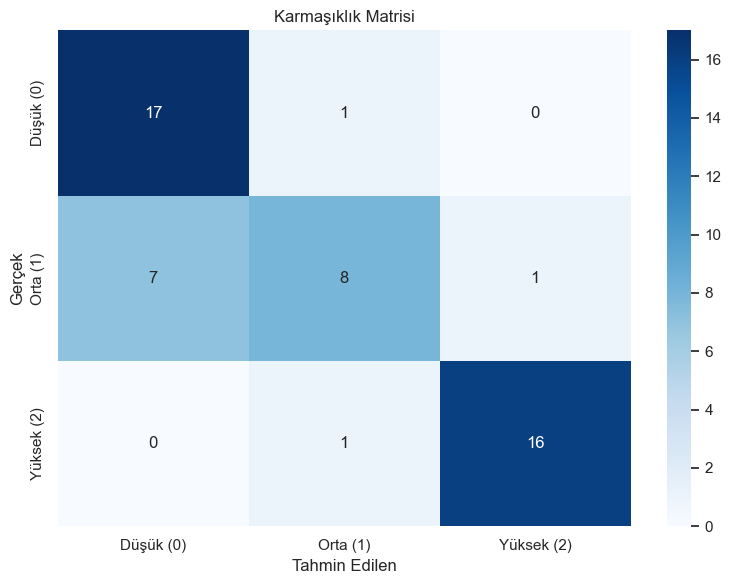

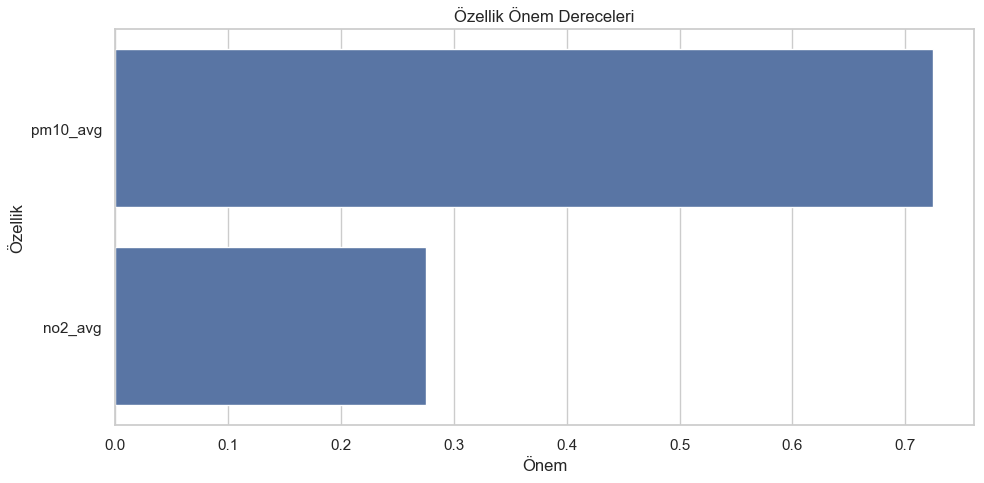


Tüm veri seti için tahmin yapılıyor...
Tüm veri seti için doğruluk oranı: 0.7098


In [21]:
# Model Eğitimi ve Test Seti Ayrımı
from sklearn.ensemble import RandomForestClassifier

# Eğitim ve test setlerini ayıralım
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")

# Random Forest modeli oluşturalım (Overfitting'i önleyen parametrelerle)
rf_model = RandomForestClassifier(
    n_estimators=30,     # Sınırlı ağaç sayısı
    max_depth=3,         # Düşük ağaç derinliği - Overfitting'i önlemek için kritik parametre
    min_samples_split=5, # Bölünme için gerekli minimum örnek - Küçük alt gruplara ayrılmayı engeller
    min_samples_leaf=3,  # Yaprak için gerekli minimum örnek - Tek örnekli yaprakları engeller
    max_features='sqrt', # Her bölünmede kullanılacak özellik sayısını sınırlar
    random_state=42,
    bootstrap=True,      # Bootstrap örnekleme kullanarak model çeşitliliğini artırır
    ccp_alpha=0.001      # Maliyet-karmaşıklık budama parametresi - Overfitting'i önlemek için
)

# Modeli eğitelim
print("\nModel eğitiliyor...")
rf_model.fit(X_train, y_train)

# Eğitim seti üzerinde performans değerlendirme
y_train_pred = rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Test seti üzerinde performans
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test seti doğruluk oranı: {accuracy:.4f}")
print(f"Eğitim seti doğruluk oranı: {train_accuracy:.4f}")

# Overfitting kontrolü
accuracy_diff = train_accuracy - accuracy
print(f"Aralarındaki fark: {accuracy_diff:.4f}")

if accuracy_diff > 0.05:
    print("⚠️ Uyarı: Model aşırı uyum (overfitting) belirtisi gösteriyor.")
else:
    print("✅ Model aşırı uyum göstermiyor, genellenebilirliği iyi görünüyor.")

# Sınıflandırma raporu
print("\nSınıflandırma raporu:")
print(classification_report(y_test, y_pred, target_names=['Düşük Risk', 'Orta Risk', 'Yüksek Risk']))

# Karmaşıklık matrisi
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Düşük (0)', 'Orta (1)', 'Yüksek (2)'],
            yticklabels=['Düşük (0)', 'Orta (1)', 'Yüksek (2)'])
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.show()

# Özellik önemleri
importance = pd.DataFrame({
    'Özellik': features,
    'Önem': rf_model.feature_importances_
}).sort_values(by='Önem', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Önem', y='Özellik', data=importance)
plt.title('Özellik Önem Dereceleri')
plt.xlabel('Önem')
plt.tight_layout()
plt.show()

# Tüm veri seti için tahmin yapma
print("\nTüm veri seti için tahmin yapılıyor...")
X_all = df_with_target[features].values
X_all_imputed = imputer.transform(X_all)  # Eksik verileri doldurma işlemi
predicted_risk = rf_model.predict(X_all_imputed)

# Tahminleri veri çerçevesine ekleyelim
df_with_target['predicted_risk'] = predicted_risk

# Genel doğruluk
accuracy_all = accuracy_score(df_with_target['asthma_risk'], df_with_target['predicted_risk'])
print(f"Tüm veri seti için doğruluk oranı: {accuracy_all:.4f}")

## Model Karşılaştırma ve Hiperparametre Optimizasyonu

RandomForest'e ek olarak farklı model algoritmalarını deneyelim ve hiperparametre optimizasyonu ile performansı iyileştirmeye çalışalım.

Çeşitli modeller karşılaştırılıyor...
RandomForest değerlendirmesi tamamlandı.
RandomForest değerlendirmesi tamamlandı.
GradientBoosting değerlendirmesi tamamlandı.
GradientBoosting değerlendirmesi tamamlandı.
AdaBoost değerlendirmesi tamamlandı.
AdaBoost değerlendirmesi tamamlandı.
SVC değerlendirmesi tamamlandı.
KNN değerlendirmesi tamamlandı.

Model karşılaştırma sonuçları (Doğruluk skoruna göre sıralı):
           Model  Accuracy  Precision   Recall  F1-Score  Time (s)
    RandomForest  0.834196   0.849699 0.834196  0.826872  2.998385
             KNN  0.826353   0.832734 0.826353  0.815821  0.105532
GradientBoosting  0.763216   0.775021 0.763216  0.759259  5.907251
        AdaBoost  0.672235   0.735342 0.672235  0.661904  1.701774
             SVC  0.375373   0.177192 0.375373  0.217037  0.255669

En iyi performanslı model: RandomForest
SVC değerlendirmesi tamamlandı.
KNN değerlendirmesi tamamlandı.

Model karşılaştırma sonuçları (Doğruluk skoruna göre sıralı):
           Model  A

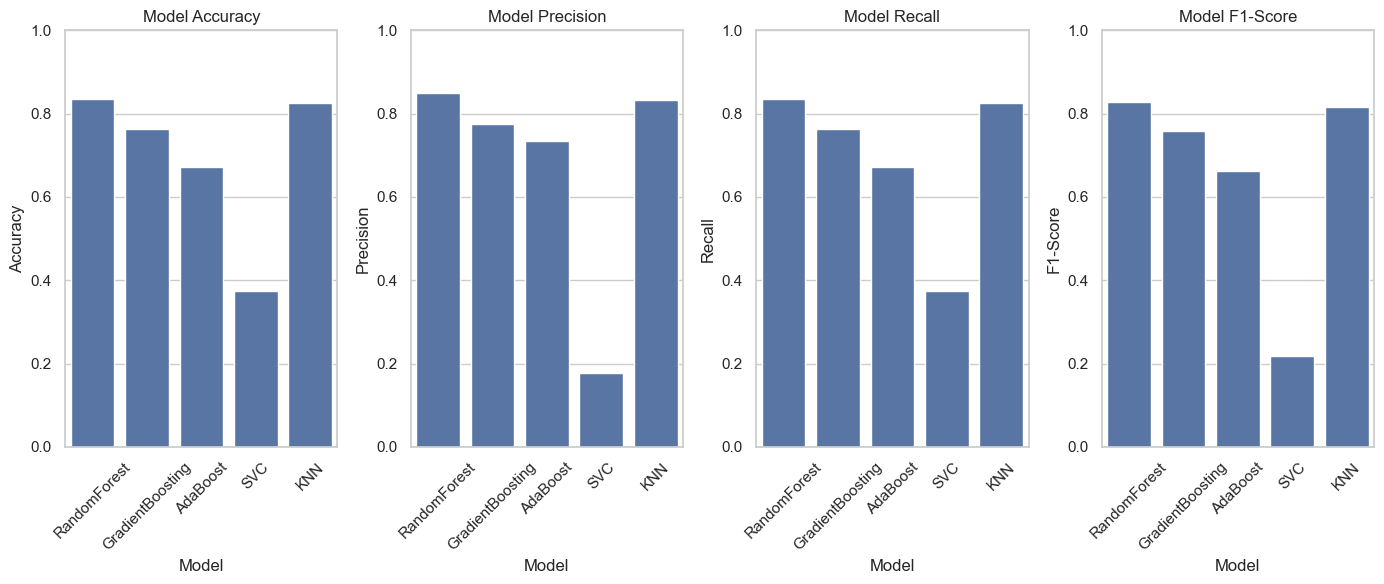

RandomForest hiperparametre optimizasyonu yapılıyor...
GridSearchCV çalıştırılıyor (RandomForest)... (Bu işlem birkaç dakika sürebilir)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [ ]:
# Farklı model algoritmalarını import edelim
import time

print("Çeşitli modeller karşılaştırılıyor...")

# Karşılaştırılacak modeller
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "SVC": SVC(random_state=42, probability=True),
    "KNN": KNeighborsClassifier()
}

# Her model için çapraz doğrulama sonuçlarını saklayalım
results = {}
cv_results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Time (s)'])

# Her modeli değerlendirelim
for name, model in models.items():
    start_time = time.time()
    # 5-fold çapraz doğrulama ile değerlendirme
    cv_accuracy = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy')
    cv_precision = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='precision_weighted')
    cv_recall = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='recall_weighted')
    cv_f1 = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1_weighted')
    
    elapsed_time = time.time() - start_time
    
    # Sonuçları kaydet
    cv_results = pd.concat([cv_results, pd.DataFrame({
        'Model': [name],
        'Accuracy': [cv_accuracy.mean()],
        'Precision': [cv_precision.mean()],
        'Recall': [cv_recall.mean()],
        'F1-Score': [cv_f1.mean()],
        'Time (s)': [elapsed_time]
    })], ignore_index=True)
    
    print(f"{name} değerlendirmesi tamamlandı.")

# Sonuçları sırala
cv_results_sorted = cv_results.sort_values(by='Accuracy', ascending=False)
print("\nModel karşılaştırma sonuçları (Doğruluk skoruna göre sıralı):")
print(cv_results_sorted.to_string(index=False))

# En iyi performanslı modeli belirleyelim
best_model_name = cv_results_sorted.iloc[0]['Model']
print(f"\nEn iyi performanslı model: {best_model_name}")

# Sonuçları görselleştirelim
plt.figure(figsize=(14, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for i, metric in enumerate(metrics):
    plt.subplot(1, 4, i+1)
    sns.barplot(x='Model', y=metric, data=cv_results)
    plt.title(f'Model {metric}')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# En iyi modeli seçelim (Gradient Boosting veya en iyi performans göstereni)
if best_model_name == "GradientBoosting" or cv_results_sorted.iloc[0]['Accuracy'] < 0.6:
    print("Gradient Boosting hiperparametre optimizasyonu yapılıyor...")
    best_model = GradientBoostingClassifier(random_state=42)
    param_grid = {
        'n_estimators': [30, 50, 100],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [2, 3, 4],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 3, 4],
        'subsample': [0.8, 0.9]
    }
    model_name = "GradientBoosting"
else:
    # En iyi modeli seçelim ve onun hiperparametre optimizasyonunu yapalım
    print(f"{best_model_name} hiperparametre optimizasyonu yapılıyor...")
    
    if best_model_name == "RandomForest":
        best_model = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [30, 50, 100],
            'max_depth': [3, 5, 7],  # None değerini çıkardık
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 3, 4],
            'max_features': ['sqrt', 'log2'],
            'ccp_alpha': [0.001, 0.01]
        }
    elif best_model_name == "AdaBoost":
        best_model = AdaBoostClassifier(random_state=42)
        param_grid = {
            'n_estimators': [30, 50, 100],
            'learning_rate': [0.05, 0.1, 0.5]
        }
    elif best_model_name == "SVC":
        best_model = SVC(probability=True, random_state=42)
        param_grid = {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }
    elif best_model_name == "KNN":
        best_model = KNeighborsClassifier()
        param_grid = {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    else:
        # Varsayılan olarak Gradient Boosting'i kullanalım
        best_model = GradientBoostingClassifier(random_state=42)
        param_grid = {
            'n_estimators': [30, 50, 100],
            'learning_rate': [0.05, 0.1],
            'max_depth': [2, 3, 4],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 3]
        }
    
    model_name = best_model_name

# Hiperparametre optimizasyonu için skorlama fonksiyonunu tanımlayalım
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted'
}

print(f"GridSearchCV çalıştırılıyor ({model_name})... (Bu işlem birkaç dakika sürebilir)")
# Sınıfların dengesizliğini göz önüne alarak sınıf ağırlıklarını ekleyelim
grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=param_grid,
    scoring=scoring,
    cv=5,
    refit='f1',  # F1 skoruna göre en iyi modeli seçelim (dengesiz veri için daha uygun)
    n_jobs=1,    # Paralel işleme sayısını 1'e sınırlandırdık
    verbose=1,
    return_train_score=True
)

# GridSearchCV'yi çalıştıralım
grid_search.fit(X_train, y_train)

# En iyi hiperparametreleri ve skorları yazdıralım
print(f"\nEn iyi hiperparametreler ({model_name}):")
print(grid_search.best_params_)

print(f"\nEn iyi çapraz doğrulama skoru ({model_name}):")
print(f"Accuracy: {grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]:.4f}")
print(f"Precision: {grid_search.cv_results_['mean_test_precision'][grid_search.best_index_]:.4f}")
print(f"Recall: {grid_search.cv_results_['mean_test_recall'][grid_search.best_index_]:.4f}")
print(f"F1 Score: {grid_search.cv_results_['mean_test_f1'][grid_search.best_index_]:.4f}")

# En iyi modeli değerlendirelim
best_model = grid_search.best_estimator_

# Test seti üzerinde tahminler
y_pred_optimized = best_model.predict(X_test)

# Optimizasyon öncesi ve sonrası başarı skorlarını karşılaştıralım
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized, average='weighted')
recall_optimized = recall_score(y_test, y_pred_optimized, average='weighted')
f1_optimized = f1_score(y_test, y_pred_optimized, average='weighted')

# Risk sınıfları için etiketler
class_names = ['Düşük Risk', 'Orta Risk', 'Yüksek Risk']

# Sonuçları karşılaştırma tablosu
comparison_df = pd.DataFrame({
    'Metrik': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'RandomForest (İlk Model)': [accuracy, precision_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted')],
    f'Optimize Edilmiş {model_name}': [accuracy_optimized, precision_optimized, recall_optimized, f1_optimized]
})

print("\nİlk model ve optimize edilmiş model karşılaştırması:")
print(comparison_df.to_string(index=False))

# Karmaşıklık matrisi
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Optimize Edilmiş {model_name} - Karmaşıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.xticks([0.5, 1.5, 2.5], ['Düşük (0)', 'Orta (1)', 'Yüksek (2)'])
plt.yticks([0.5, 1.5, 2.5], ['Düşük (0)', 'Orta (1)', 'Yüksek (2)'])
plt.show()

# Tüm veri seti üzerinde optimize edilmiş modeli uygulayalım
X_all = df_with_target[features].values
X_all_imputed = imputer.transform(X_all)  # Eksik değerleri doldurma
optimized_predictions = best_model.predict(X_all_imputed)

# Tahmin sonuçlarını veri setine ekleyelim
df_with_target['optimized_predicted_risk'] = optimized_predictions

# Optimize edilmiş modelin performansını ölçelim
optimized_accuracy_all = accuracy_score(df_with_target['asthma_risk'], df_with_target['optimized_predicted_risk'])
print(f"Optimize edilmiş modelle PM10 ve NO2'yi kullanarak PM2.5 bazlı riski tahmin başarısı: {optimized_accuracy_all:.4f}")
print(f"İlk modele göre değişim: {optimized_accuracy_all - accuracy_all:.4f} ({(optimized_accuracy_all - accuracy_all) / accuracy_all * 100:.2f}%)")

## Tüm Şehirlerin Risk Derecesine Göre Harita Görselleştirmesi

Tüm şehirler için tahmin edilen astım risk derecelerine göre renkli bir harita oluşturalım ve optimize edilmiş modelimizi kaydedelim.

In [ ]:
# Tüm şehirlerin risk derecesine göre harita görselleştirmesi
import folium
import pickle
from datetime import datetime

# Şehir bazlı risk tahminlerini analiz edelim
city_risk_analysis = df_with_target.groupby('city')[["asthma_risk", "optimized_predicted_risk"]].mean().reset_index()
city_risk_analysis = city_risk_analysis.sort_values(by="optimized_predicted_risk", ascending=False)

print("Şehirlerin ortalama risk derecelerine göre sıralaması (Tüm Şehirler):")
print(city_risk_analysis.head(15).to_string(index=False))

print(f"\nToplam analiz edilen şehir sayısı: {len(city_risk_analysis)}")

# Risk derecesine göre renk belirleme fonksiyonu
def get_risk_color(risk_score):
    if risk_score < 0.5:  # Düşük Risk
        return "green"
    elif risk_score < 1.5:  # Orta Risk
        return "orange"
    else:  # Yüksek Risk
        return "red"

# Risk haritası için şehir lokasyonları
city_locations = location_info.groupby('city').agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'measurement_count': 'sum'
}).reset_index()

# Şehirlerin risk değerlerini ekleyelim
city_map_data = pd.merge(city_locations, city_risk_analysis, on='city', how='left')

# Türkiye haritasını oluşturalım
turkey_risk_map = folium.Map(location=[39.0, 35.0], zoom_start=6, tiles='CartoDB positron')

# Risk seviyelerine göre renk bilgisini içeren lejant
risk_legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index:9999; background-color:white; 
     padding:10px; border:2px solid grey; border-radius:5px">
<h4>Astım Riski Seviyeleri</h4>
<div><span style="background-color:green; display:inline-block; width:15px; height:15px; 
     border-radius:50%; margin-right:5px"></span>Düşük Risk (0)</div>
<div><span style="background-color:orange; display:inline-block; width:15px; height:15px; 
     border-radius:50%; margin-right:5px"></span>Orta Risk (1)</div>
<div><span style="background-color:red; display:inline-block; width:15px; height:15px; 
     border-radius:50%; margin-right:5px"></span>Yüksek Risk (2)</div>
</div>
'''
turkey_risk_map.get_root().html.add_child(folium.Element(risk_legend_html))

# Tüm şehirleri haritada gösterelim
for idx, row in city_map_data.iterrows():
    if pd.notna(row['optimized_predicted_risk']) and pd.notna(row['latitude']) and pd.notna(row['longitude']):
        # Risk rengini belirle
        risk_color = get_risk_color(row['optimized_predicted_risk'])
        
        # Daire büyüklüğünü ölçüm sayısına göre ayarla (normalizasyon)
        size = np.sqrt(row['measurement_count']) / 10
        size = max(6, min(20, size))  # Minimum ve maksimum büyüklük
        
        # Popup içeriği
        popup_text = f"<strong>Şehir:</strong> {row['city']}<br>"
        popup_text += f"<strong>Gerçek Risk:</strong> {row['asthma_risk']:.2f}<br>"
        popup_text += f"<strong>Tahmin Edilen Risk:</strong> {row['optimized_predicted_risk']:.2f}<br>"
        popup_text += f"<strong>Ölçüm Sayısı:</strong> {row['measurement_count']:,}"
        
        # Şehir marker'ını haritaya ekle
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=size,
            popup=folium.Popup(popup_text, max_width=300),
            color=risk_color,
            fill=True,
            fill_color=risk_color,
            fill_opacity=0.7,
            weight=2
        ).add_to(turkey_risk_map)

# Haritayı göster
print("\nTüm şehirlerin risk derecesine göre renklendirilmiş haritası:")
display(turkey_risk_map)

# Haritayı HTML olarak kaydet
turkey_risk_map.save("astim_risk_haritasi.html")
print("\nRisk haritası 'astim_risk_haritasi.html' olarak kaydedildi.")

# Risk tahminlerinin doğruluğu
print("\nGerçek ve tahmin edilen risk seviyeleri karşılaştırması:")
risk_comparison = pd.crosstab(df_with_target['asthma_risk'], 
                             df_with_target['optimized_predicted_risk'],
                             rownames=['Gerçek Risk'], 
                             colnames=['Tahmin Edilen Risk'])
print(risk_comparison)

# Risk seviyelerine göre şehir sayıları
risk_distribution = city_risk_analysis['optimized_predicted_risk'].apply(lambda x: 'Düşük' if x < 0.5 else ('Orta' if x < 1.5 else 'Yüksek')).value_counts()
print("\nŞehirlerin risk seviyesi dağılımı:")
for risk_level, count in risk_distribution.items():
    print(f"{risk_level} Risk: {count} şehir ({count/len(city_risk_analysis)*100:.1f}%)")

# En yüksek ve en düşük riskli şehirler
print("\nEn yüksek riskli 10 şehir:")
highest_risk = city_risk_analysis.head(10)
for idx, row in highest_risk.iterrows():
    risk_level = 'Düşük' if row['optimized_predicted_risk'] < 0.5 else ('Orta' if row['optimized_predicted_risk'] < 1.5 else 'Yüksek')
    print(f"{row['city']}: {row['optimized_predicted_risk']:.2f} ({risk_level} Risk)")

print("\nEn düşük riskli 10 şehir:")
lowest_risk = city_risk_analysis.tail(10)
for idx, row in lowest_risk.iterrows():
    risk_level = 'Düşük' if row['optimized_predicted_risk'] < 0.5 else ('Orta' if row['optimized_predicted_risk'] < 1.5 else 'Yüksek')
    print(f"{row['city']}: {row['optimized_predicted_risk']:.2f} ({risk_level} Risk)")

# Optimize edilmiş modeli pickle formatında kaydetme
model_info = {
    'model': best_model,
    'features': features,
    'imputer': imputer,
    'model_type': model_name,
    'best_params': grid_search.best_params_,
    'accuracy': optimized_accuracy_all,
    'train_date': datetime.now().strftime("%Y-%m-%d"),
    'cities_analyzed': len(city_risk_analysis),
    'total_locations': len(df_with_target)
}

# Modeli kaydet
with open('optimized_asthma_risk_model.pkl', 'wb') as file:
    pickle.dump(model_info, file)

print("\nOptimize edilmiş model başarıyla kaydedildi: optimized_asthma_risk_model.pkl")

# Model bilgilerini göster
print("\nModel bilgileri:")
print(f"Model tipi: {model_name}")
print(f"Kullanılan özellikler: {features}")
print(f"Doğruluk oranı: {optimized_accuracy_all:.4f}")
print(f"Eğitim tarihi: {datetime.now().strftime('%Y-%m-%d')}")
print(f"Analiz edilen şehir sayısı: {len(city_risk_analysis)}")
print(f"Toplam lokasyon sayısı: {len(df_with_target)}")
print(f"Kullanılan veri dosyası sayısı: Data klasöründeki tüm OpenAQ dosyaları")

Şehirlerin ortalama risk derecelerine göre sıralaması:
    city  asthma_risk  optimized_predicted_risk
  Amasya          2.0                       2.0
 Bayburt          2.0                       2.0
    Ağrı          2.0                       2.0
  Batman          2.0                       2.0
  Bartın          2.0                       2.0
Erzincan          2.0                       2.0
  Bingöl          2.0                       2.0
   Fatsa          2.0                       2.0
   Tokat          2.0                       2.0
     Muş          2.0                       2.0

Şehirlerin risk derecesine göre renklendirilmiş harita:



Risk haritası 'astim_risk_haritasi.html' olarak kaydedildi.

Gerçek ve tahmin edilen risk seviyeleri karşılaştırması:
Tahmin Edilen Risk  0.0  1.0  2.0
Gerçek Risk                      
0.0                   6    0    0
1.0                   2   33    4
2.0                   0    5   51

Optimize edilmiş model başarıyla kaydedildi: optimized_asthma_risk_model.pkl

Model bilgileri:
Model tipi: GradientBoosting
Kullanılan özellikler: ['pm10_avg', 'no2_avg']
Doğruluk oranı: 0.8911
Eğitim tarihi: 2025-06-03
